# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
farthest_point = manager.Value("s", "test")

# Non shared resources
filename = 'casa-lc-coreset'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def combined_sampling(aspect_model, sentiment_model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    final_cp = False
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)
                
    accelerator.wait_for_everyone()
    if not final_cp:
        aspect_dataset = AspectDetectionDataset(
            X_pool, 
            [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
            label_mapping, 
            tokenizer, 
            max_length=sequence_length
        )
        aspect_loader = DataLoader(
            aspect_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

        start_time = time.time()

        lc_indices = least_confidence_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples)
        lc_indices = [remaining_indices[i] for i in lc_indices]
        accelerator.print(f"Got {len(lc_indices)} samples from lc")

        coreset_indices = coreset_sampling(aspect_model, sentiment_model, farthest_point, X_pool, device, target_samples)
        coreset_indices = [remaining_indices[i] for i in coreset_indices]
        accelerator.print(f"Got {len(coreset_indices)} samples from coreset")

        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(lc_indices).union(set(coreset_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'fuel': [y_train[i][0] for i in temp],
                    'machine': [y_train[i][1] for i in temp],
                    'others': [y_train[i][2] for i in temp],
                    'part': [y_train[i][3] for i in temp],
                    'price': [y_train[i][4] for i in temp],
                    'service': [y_train[i][5] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

In [21]:
def least_confidence_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples):
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            aspect_outputs[batch['ori_indices'][i].item()] = np.max(preds[i].cpu().numpy())
            
            for j in range(len(preds[i])):
                if int(preds[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])
    
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        with torch.no_grad():
            outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            ori_index = batch['ori_indices'][i].item()
            if ori_index in sentiment_outputs.keys():
                max_pred = np.max(preds[i].cpu().numpy())
                sentiment_outputs[ori_index] = max_pred if max_pred > sentiment_outputs[ori_index] else sentiment_outputs[ori_index]
            else:
                sentiment_outputs[ori_index] = np.max(preds[i].cpu().numpy())

    aspect_outputs = dict(sorted(aspect_outputs.items()))

    # accelerator.print(aspect_outputs)
    for key, val in sentiment_outputs.items():
        aspect_outputs[key] = 1 - ((val + aspect_outputs[key]) / 2)

    # accelerator.print(aspect_outputs)
    uncertainties = np.array(list(aspect_outputs.values()))
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    threshold = np.percentile(uncertainties, 90)
    items_greater_than_average = uncertainties[uncertainties >= threshold]
    least_confident_indices = sorted_unc[:target_samples]

    return least_confident_indices

In [22]:
def coreset_sampling(aspect_model, sentiment_model, farthest_point, X_pool, device, target_samples):
    farthest_data = farthest_point.value
    if farthest_data is not None:
        X_pool.append(farthest_data)

    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []
    
    aspect_outputs = dict(sorted(aspect_outputs.items()))

    if len(data) > 0:
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

    embeddings = np.array(list(aspect_outputs.values()))
    distance_matrix = pairwise_distances(embeddings)
    selected_indices = distance_matrix.shape[0] - 1 if farthest_data is not None else 0

    # Calculate the minimum distance from selected points to all other points
    min_distances = distance_matrix[selected_indices]

    sorted_dist = np.argsort(min_distances)
    sorted_dist = sorted_dist[::-1]
    farthest_point.value = aspect_dataset[sorted_dist[0]]['ori_text']

    threshold = np.percentile(min_distances, 90)
    candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set

    return sorted_dist[:target_samples]

# MAIN LOOP

In [23]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            farthest_point,
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [24]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6756, Accuracy: 0.7731, F1 Micro: 0.8711, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5958, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5785, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.513, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.5006, Accuracy: 0.7924, F1 Micro: 0.8829, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4695, Accuracy: 0.7954, F1 Micro: 0.8846, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4328, Accuracy: 0.7969, F1 Micro: 0.8857, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.4369, Accuracy: 0.7932, F1 Micro: 0.8832, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.415, Accuracy: 0.7917, F1 Micro: 0.8816, F1 Macro: 0.8789
Epoch 10/10, Train Loss: 0.3884, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7162, Accuracy: 0.2857, F1 Micro: 0.2857, F1 Macro: 0.2222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6764, Accuracy: 0.5, F1 Micro: 0.5, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6621, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.6053, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5803, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5674, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4789, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4895, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Epoch 9/10, Train Loss: 0.4054, Accuracy: 0.7143, F1 Micro: 0.7143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.626, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5419, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5041, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4936, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.459, Accuracy: 0.8028, F1 Micro: 0.8888, F1 Macro: 0.8874
Epoch 6/10, Train Loss: 0.4236, Accuracy: 0.8021, F1 Micro: 0.8883, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3954, Accuracy: 0.8333, F1 Micro: 0.9038, F1 Macro: 0.9024
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3361, Accuracy: 0.8549, F1 Micro: 0.9149, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3088, Accuracy: 0.8854, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6227, Accuracy: 0.6834, F1 Micro: 0.6834, F1 Macro: 0.406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5016, Accuracy: 0.6834, F1 Micro: 0.6834, F1 Macro: 0.406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5023, Accuracy: 0.7186, F1 Micro: 0.7186, F1 Macro: 0.5146
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4243, Accuracy: 0.7387, F1 Micro: 0.7387, F1 Macro: 0.5771
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3663, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2626, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1986, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8946
Epoch 8/10, Train Loss: 0.1467, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8805
Epoch 9/10, Train Loss: 0.1393, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8823
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.607, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5383, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Epoch 3/10, Train Loss: 0.5193, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4926, Accuracy: 0.8118, F1 Micro: 0.8928, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.454, Accuracy: 0.814, F1 Micro: 0.8943, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3933, Accuracy: 0.8676, F1 Micro: 0.9217, F1 Macro: 0.9207
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.336, Accuracy: 0.9033, F1 Micro: 0.9414, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2861, Accuracy: 0.9234, F1 Micro: 0.953, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2388, Accuracy: 0.933, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.648, Accuracy: 0.6767, F1 Micro: 0.6767, F1 Macro: 0.4036
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5359, Accuracy: 0.6983, F1 Micro: 0.6983, F1 Macro: 0.4912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4312, Accuracy: 0.8879, F1 Micro: 0.8879, F1 Macro: 0.871
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2398, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.9085
Epoch 5/10, Train Loss: 0.2404, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.194, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.9102
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8983
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.9113
Epoch 9/10, Train Loss: 0.1087, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8954
Epoch 10/10, Train Loss: 0.1072, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5954, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5201, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5001, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4699, Accuracy: 0.8036, F1 Micro: 0.8894, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4073, Accuracy: 0.8802, F1 Micro: 0.9285, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3393, Accuracy: 0.9152, F1 Micro: 0.9482, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2673, Accuracy: 0.9308, F1 Micro: 0.9567, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2227, Accuracy: 0.9472, F1 Micro: 0.967, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5713, Accuracy: 0.6834, F1 Micro: 0.6834, F1 Macro: 0.406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4815, Accuracy: 0.8301, F1 Micro: 0.8301, F1 Macro: 0.7884
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2443, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8743
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9096
Epoch 5/10, Train Loss: 0.2059, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9031
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9025
Epoch 7/10, Train Loss: 0.1424, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8757
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.891
Epoch 9/10, Train Loss: 0.1174, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8915
Epoch 10/10, Train Loss: 0.0867, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.9008

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.578, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Epoch 2/10, Train Loss: 0.5138, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4654, Accuracy: 0.8132, F1 Micro: 0.8935, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4092, Accuracy: 0.8653, F1 Micro: 0.9204, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3348, Accuracy: 0.9271, F1 Micro: 0.9553, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2606, Accuracy: 0.9375, F1 Micro: 0.9611, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2064, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1534, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1313, Accuracy: 0.9591, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6383, Accuracy: 0.6719, F1 Micro: 0.6719, F1 Macro: 0.4338
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4684, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2644, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9061
Epoch 4/10, Train Loss: 0.2599, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1778, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9221
Epoch 6/10, Train Loss: 0.157, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9161
Epoch 7/10, Train Loss: 0.1339, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8993
Epoch 8/10, Train Loss: 0.1657, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.9022
Epoch 9/10, Train Loss: 0.1328, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9031
Epoch 10/10, Train Loss: 0.0944, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9145

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5639, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4811, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4388, Accuracy: 0.8274, F1 Micro: 0.901, F1 Macro: 0.9001
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3577, Accuracy: 0.9152, F1 Micro: 0.948, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2799, Accuracy: 0.9405, F1 Micro: 0.963, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2188, Accuracy: 0.9457, F1 Micro: 0.9659, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1667, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1293, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9705
Epoch 9/10, Train Loss: 0.1038, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5584, Accuracy: 0.7126, F1 Micro: 0.7126, F1 Macro: 0.5529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3888, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9237
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9153
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9032
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1177, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1019, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9247
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5542, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4792, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4379, Accuracy: 0.8661, F1 Micro: 0.9214, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3435, Accuracy: 0.9368, F1 Micro: 0.9611, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2454, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1871, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1401, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.1096, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0903, Accuracy: 0.9606, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6061, Accuracy: 0.7183, F1 Micro: 0.7183, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4203, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2546, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9367
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.929
Epoch 5/10, Train Loss: 0.1871, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9305
Epoch 6/10, Train Loss: 0.1092, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9421
Epoch 8/10, Train Loss: 0.1093, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9389
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9347
Epoch 10/10, Train Loss: 0.0935, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9389

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5533, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4858, Accuracy: 0.8028, F1 Micro: 0.889, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4104, Accuracy: 0.8847, F1 Micro: 0.9312, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3218, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2311, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1794, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9717
Epoch 7/10, Train Loss: 0.1418, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1106, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9701
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6086, Accuracy: 0.7969, F1 Micro: 0.7969, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3751, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.25, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.13, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9391
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9311
Epoch 9/10, Train Loss: 0.1051, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9192
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5452, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4953, Accuracy: 0.8162, F1 Micro: 0.8955, F1 Macro: 0.895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3903, Accuracy: 0.9323, F1 Micro: 0.9585, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2862, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2081, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Epoch 6/10, Train Loss: 0.1519, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 0.9691
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6503, Accuracy: 0.7016, F1 Micro: 0.7016, F1 Macro: 0.5033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3896, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2236, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9351
Epoch 5/10, Train Loss: 0.1848, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8991
Epoch 6/10, Train Loss: 0.1548, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9285
Epoch 7/10, Train Loss: 0.1241, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9228
Epoch 8/10, Train Loss: 0.1067, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.931
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8956
Epoch 10/10, Train Loss: 0.0828, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9075

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.538, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4628, Accuracy: 0.811, F1 Micro: 0.893, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3748, Accuracy: 0.9286, F1 Micro: 0.9562, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.273, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2038, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1506, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5835, Accuracy: 0.8824, F1 Micro: 0.8824, F1 Macro: 0.8652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3527, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2728, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9396
Epoch 4/10, Train Loss: 0.1942, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8993
Epoch 5/10, Train Loss: 0.2172, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9235
Epoch 6/10, Train Loss: 0.1542, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9235
Epoch 7/10, Train Loss: 0.1316, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9396
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9159
Epoch 10/10, Train Loss: 0.0983, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9223

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5561, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4756, Accuracy: 0.8043, F1 Micro: 0.8895, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3812, Accuracy: 0.9241, F1 Micro: 0.9537, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2651, Accuracy: 0.9479, F1 Micro: 0.9678, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.191, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9714
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5805, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.8384
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3203, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9245
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9304
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9262
Epoch 7/10, Train Loss: 0.1506, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0943, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9338
Epoch 10/10, Train Loss: 0.074, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5437, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4631, Accuracy: 0.817, F1 Micro: 0.8959, F1 Macro: 0.8948
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3446, Accuracy: 0.9353, F1 Micro: 0.96, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2389, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9729
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1106, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.965, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5462, Accuracy: 0.8828, F1 Micro: 0.8828, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2998, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9349
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1864, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9372
Epoch 6/10, Train Loss: 0.1561, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9334
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.082, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9384
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.554, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4582, Accuracy: 0.8594, F1 Micro: 0.9176, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3521, Accuracy: 0.9375, F1 Micro: 0.961, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2332, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5924, Accuracy: 0.8826, F1 Micro: 0.8826, F1 Macro: 0.8624
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2826, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9329
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9278
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Epoch 7/10, Train Loss: 0.1191, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.917
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0601, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5521, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4432, Accuracy: 0.8765, F1 Micro: 0.9269, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3176, Accuracy: 0.9442, F1 Micro: 0.9653, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2214, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5666, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3123, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9322
Epoch 3/10, Train Loss: 0.2146, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9074
Epoch 4/10, Train Loss: 0.1736, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.94
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9273
Epoch 8/10, Train Loss: 0.1067, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9122
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8931
Epoch 10/10, Train Loss: 0.0901, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9188

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4451, Accuracy: 0.8936, F1 Micro: 0.9362, F1 Macro: 0.9353
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.307, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1991, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5509, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.8723
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2996, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9139
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8995
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9336
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9288
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9145
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9292
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.93
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.9028
Epoch 10/10, Train Loss: 0.071, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.914

Sentiment analysis accuracy: 0.9405, F1 Micro: 0.9405,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5407, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4387, Accuracy: 0.8884, F1 Micro: 0.9337, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3022, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2083, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.9531, F1 Micro: 0.9702, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5197, Accuracy: 0.8657, F1 Micro: 0.8657, F1 Macro: 0.8586
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2714, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9374
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9338
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9515, F1 Micro: 0.9515, F1 Macro: 0.9458
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9418
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9103
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9418
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9418
Epoch 10/10, Train Loss: 0.0539, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9411

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5411, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4453, Accuracy: 0.9003, F1 Micro: 0.9401, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2909, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9689
Epoch 4/10, Train Loss: 0.1969, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5496, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9114
Epoch 2/10, Train Loss: 0.3017, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.9054
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1861, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9397
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9287
Epoch 6/10, Train Loss: 0.1266, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9364
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9547, F1 Micro: 0.9547, F1 Macro: 0.9487
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9194
Epoch 10/10, Train Loss: 0.0513, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9319

Sentiment analysis accuracy: 0.9547, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5275, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4246, Accuracy: 0.9077, F1 Micro: 0.9443, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2866, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9788
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9775
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 10/10, Train Loss: 0.0489, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.529, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9389
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.931
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9389
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9479
Epoch 10/10, Train Loss: 0.0355, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.415, Accuracy: 0.9226, F1 Micro: 0.9526, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2757, Accuracy: 0.9501, F1 Micro: 0.9692, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Epoch 10/10, Train Loss: 0.051, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4849, Accuracy: 0.8835, F1 Micro: 0.8835, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2856, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9321
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.92
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.92
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9125
Epoch 9/10, Train Loss: 0.066, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9204
Epoch 10/10, Train Loss: 0.0524, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5238, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3897, Accuracy: 0.933, F1 Micro: 0.9588, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2608, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9775
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9758
Epoch 10/10, Train Loss: 0.0507, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4905, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9101
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1501, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9389
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1192, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9382
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8945
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9105
Epoch 10/10, Train Loss: 0.0606, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4125, Accuracy: 0.9159, F1 Micro: 0.9488, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2655, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9774
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0464, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5041, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1506, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9458
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9323
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9274
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9446, F1 Micro: 0.9446, F1 Macro: 0.9378
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9259
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9259
Epoch 10/10, Train Loss: 0.0534, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9138

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5397, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4046, Accuracy: 0.9256, F1 Micro: 0.9542, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2706, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9792
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9772
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4701, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9338
Epoch 3/10, Train Loss: 0.1484, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.9132
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1248, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9377
Epoch 5/10, Train Loss: 0.0873, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0779, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9423
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.9091
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.938
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9338
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.9476, F1 Micro: 0.9476, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5272, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3955, Accuracy: 0.936, F1 Micro: 0.9605, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.458, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9242
Epoch 2/10, Train Loss: 0.216, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9092
Epoch 3/10, Train Loss: 0.1537, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9167
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9094
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9206
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9357
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0815, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9341
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9234
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9234

Sentiment analysis accuracy: 0.9427, F1 Micro: 0.9427,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5244, Accuracy: 0.8073, F1 Micro: 0.8911, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3908, Accuracy: 0.9308, F1 Micro: 0.9575, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2435, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9786
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.979
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4898, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9247
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1562, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1279, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0992, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9319
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9279
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9089
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.905
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9234
Epoch 10/10, Train Loss: 0.0541, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9093

Sentiment analysis acc

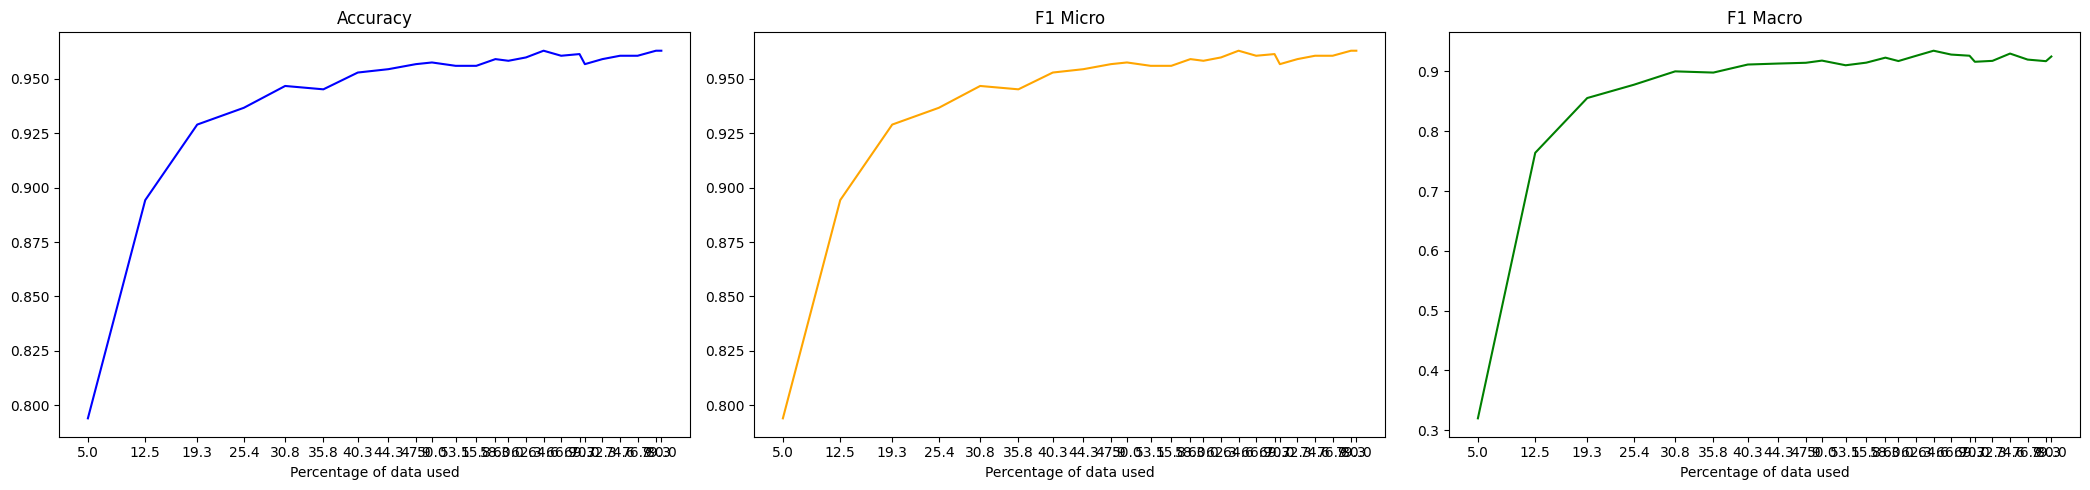

In [25]:
active_learning(seeds[0], 0)